In [ ]:
import sys
print(sys.version)


3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


# importing modules

In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.6 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


# initialisation of parameters

In [ ]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 600    # Size of the train dataset
n_test = 50     # Size of the test dataset

SAVE_PATH = "./"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator


# dataset loading

In [ ]:
mnist_dataset = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
train_images.shape

(600, 28, 28, 1)

# Circuit creation

## 4*4 kernel size

In [ ]:
kernel_size = 16
dev = qml.device("default.qubit", wires=kernel_size)
# Random circuit parameters
rand_params4 = np.random.uniform(high=2 * np.pi, size=(n_layers, kernel_size))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 9 classical input values
    for j in range(kernel_size):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params4, wires=list(range(kernel_size)))

    # Measurement producing 16 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(kernel_size)]

# 3*3 kernel size

In [ ]:

kernel_size = 9
dev = qml.device("default.qubit", wires=kernel_size)
# Random circuit parameters
rand_params3 = np.random.uniform(high=2 * np.pi, size=(n_layers, kernel_size))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 9 classical input values
    for j in range(kernel_size):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params3, wires=list(range(kernel_size)))

    # Measurement producing 9 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(kernel_size)]

# 2*2 kernel size

In [ ]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params2 = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params2, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

# Quantum Convolution

# 4*4 kernel

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    output_size = 7  # since 28 / 4 = 7
    out = np.zeros((output_size, output_size, 16))  # output array has 16 channels now

    # Loop over the coordinates of the top-left pixel of 4x4 squares
    for j in range(0, 28, 4):
        for k in range(0, 28, 4):
            # Process a squared 4x4 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k], image[j, k+1], image[j, k+2], image[j, k+3],
                    image[j+1, k], image[j+1, k+1], image[j+1, k+2], image[j+1, k+3],
                    image[j+2, k], image[j+2, k+1], image[j+2, k+2], image[j+2, k+3],
                    image[j+3, k], image[j+3, k+1], image[j+3, k+2], image[j+3, k+3]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/4, k/4)
            for c in range(16):
                out[j // 4, k // 4, c] = q_results[c]
    return out


# 3*3 kernel

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    output_size = 9  # since 28 / 3 ≈ 9
    out = np.zeros((output_size, output_size, 9))  # output array has 9 channels now

    # Loop over the coordinates of the top-left pixel of 3X3 squares
    for j in range(0, 26, 3):
        for k in range(0, 26, 3):
            # Process a squared 3x3 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k], image[j, k+1], image[j, k+2],
                    image[j+1, k], image[j+1, k+1], image[j+1, k+2],
                    image[j+2, k], image[j+2, k+1], image[j+2, k+2]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(9):
                out[j // 3, k // 3, c] = q_results[c]
    return out

# 2*2 kernel

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

# Quantum pre-processing

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:


# Seeing sample images from dataset

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

# Neural Network with quantum convolution

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Define the MyModel function
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# Function to train the model and return the val_accuracy and val_loss history
def train_and_evaluate():
    # Set seeds for reproducibility
    np.random.seed(0)
    tf.random.set_seed(0)

    # Initialize and compile the model
    q_model = MyModel()

    # Fit the model
    q_history = q_model.fit(
        q_train_images,
        train_labels,
        validation_data=(q_test_images, test_labels),
        batch_size=4,
        epochs=n_epochs,
        verbose=2,
        shuffle=False  # Disable shuffling for consistency
    )

    # Return the val_accuracy and val_loss history
    return q_history.history['val_accuracy'], q_history.history['val_loss']

# Number of runs
num_runs = 20
val_accuracies_all = []
val_losses_all = []

# Run the training process multiple times and collect val_accuracy and val_loss histories
for i in range(num_runs):
    val_accuracies, val_losses = train_and_evaluate()
    val_accuracies_all.append(val_accuracies)
    val_losses_all.append(val_losses)
    print(f"Run {i + 1} completed")

# Convert lists to numpy arrays for easier averaging
val_accuracies_all = np.array(val_accuracies_all)
val_losses_all = np.array(val_losses_all)

# Calculate the average val_accuracy and val_loss for each epoch
average_val_accuracies = np.mean(val_accuracies_all, axis=0)
average_val_losses = np.mean(val_losses_all, axis=0)


# Normal Convolution Neural Network

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Define the MyModel function
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# Function to train the model and return the val_accuracy and val_loss history
def train_and_evaluate():
    # Set seeds for reproducibility
    np.random.seed(0)
    tf.random.set_seed(0)

    # Initialize and compile the model
    c_model = MyModel()

    # Fit the model
    c_history = c_model.fit(
        train_images,
        train_labels,
        validation_data=(test_images, test_labels),
        batch_size=4,
        epochs=n_epochs,
        verbose=2,
        shuffle=False  # Disable shuffling for consistency
    )

    # Return the val_accuracy and val_loss history
    return c_history.history['val_accuracy'], c_history.history['val_loss']

# Number of runs
num_runs = 20
val_accuracies_all = []
val_losses_all = []

# Run the training process multiple times and collect val_accuracy and val_loss histories
for i in range(num_runs):
    val_accuracies, val_losses = train_and_evaluate()
    val_accuracies_all.append(val_accuracies)
    val_losses_all.append(val_losses)
    print(f"Run {i + 1} completed")

# Convert lists to numpy arrays for easier averaging
val_accuracies_all = np.array(val_accuracies_all)
val_losses_all = np.array(val_losses_all)

# Calculate the average val_accuracy and val_loss for each epoch
average_val_accuracies_c = np.mean(val_accuracies_all, axis=0)
average_val_losses_c = np.mean(val_losses_all, axis=0)


Epoch 1/30
150/150 - 1s - 6ms/step - accuracy: 0.5000 - loss: 1.4533 - val_accuracy: 0.6400 - val_loss: 1.0140
Epoch 2/30
150/150 - 0s - 1ms/step - accuracy: 0.7217 - loss: 0.8930 - val_accuracy: 0.6600 - val_loss: 0.8757
Epoch 3/30
150/150 - 0s - 2ms/step - accuracy: 0.7717 - loss: 0.7449 - val_accuracy: 0.6800 - val_loss: 0.8151
Epoch 4/30
150/150 - 0s - 2ms/step - accuracy: 0.7983 - loss: 0.6564 - val_accuracy: 0.6800 - val_loss: 0.7777
Epoch 5/30
150/150 - 0s - 2ms/step - accuracy: 0.8217 - loss: 0.5922 - val_accuracy: 0.6800 - val_loss: 0.7516
Epoch 6/30
150/150 - 0s - 2ms/step - accuracy: 0.8417 - loss: 0.5416 - val_accuracy: 0.6800 - val_loss: 0.7320
Epoch 7/30
150/150 - 0s - 2ms/step - accuracy: 0.8550 - loss: 0.4999 - val_accuracy: 0.6800 - val_loss: 0.7169
Epoch 8/30
150/150 - 0s - 2ms/step - accuracy: 0.8667 - loss: 0.4647 - val_accuracy: 0.6400 - val_loss: 0.7045
Epoch 9/30
150/150 - 0s - 1ms/step - accuracy: 0.8850 - loss: 0.4344 - val_accuracy: 0.6400 - val_loss: 0.6939
E

In [ ]:
#before running the plot code below run for all the kernel one by one:

#first run 2*2 size quantum circuit and then 2*2 size quantum convolution and then run to store the values
vaq2 = average_val_accuracies
valq2 = average_val_losses


In [ ]:

#first run 3*3 size quantum circuit and then 3*3 size quantum convolution and then run to store the values
vaq3 = average_val_accuracies
valq3 = average_val_losses

In [ ]:
#first run 4*4 size quantum circuit and then 4*4 size quantum convolution and then run to store the values
vaq4 = average_val_accuracies
valq4 = average_val_losses

# Plotting code for all the three kernels + CNN with quantum convolution

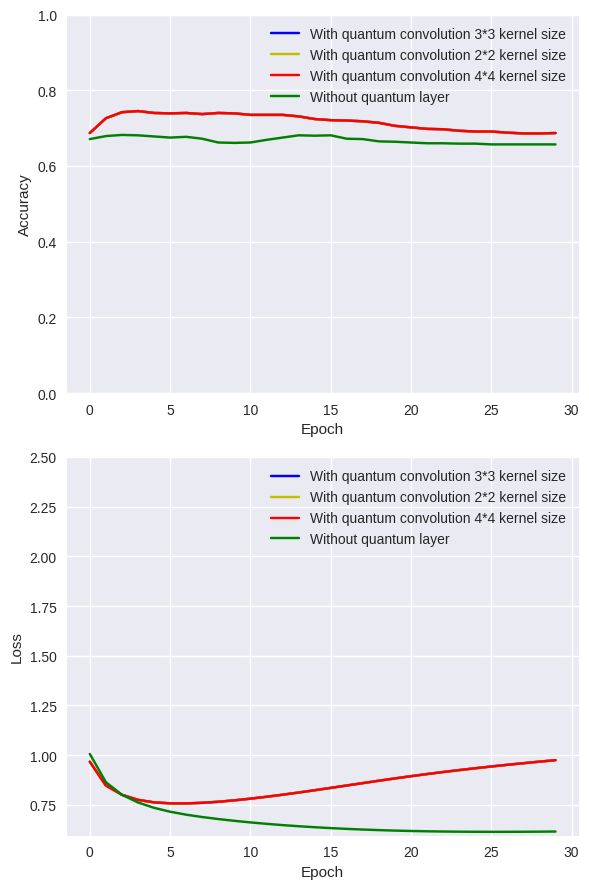

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))


ax1.plot(vaq3, "-b", label="With quantum convolution 3*3 kernel size")
ax1.plot(vaq2, "-y", label="With quantum convolution 2*2 kernel size")
ax1.plot(vaq4, "-r", label="With quantum convolution 4*4 kernel size")
ax1.plot(average_val_accuracies_c, "-g", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(valq3, "-b", label="With quantum convolution 3*3 kernel size")
ax2.plot(valq2, "-y", label="With quantum convolution 2*2 kernel size")
ax2.plot(valq4, "-r", label="With quantum convolution 4*4 kernel size")
ax2.plot(average_val_losses_c, "-g", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()